# Modules

In [172]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Data

In [2]:
data = pd.read_csv("Datos/riesgo.csv")

In [7]:
data.head()

,Pais,NacimientoA,Anticonceptivo,Aborto,Anemia,Atencion prenatal,Parto asisitido,VIH,Infecunidad,NacimientosM,Muertes,Calificacion
0,Italia,1,78,1,10,100.0,100.0,1,6,1.2,4,6.6
1,Dinamarca,1,78,1,8,100.0,99.0,1,6,1.8,3,6.7
2,Noruega,2,76,1,17,95.0,100.0,1,5,1.8,3,8.1
3,Suecia,1,78,1,17,100.0,100.0,1,5,2.0,5,8.4
4,Bélgica,1,79,1,17,90.0,100.0,1,7,1.6,3,8.7


In [27]:
pd.isna(data["Parto asisitido"][114])

True

# Preprocessing

## Missings

<AxesSubplot: >

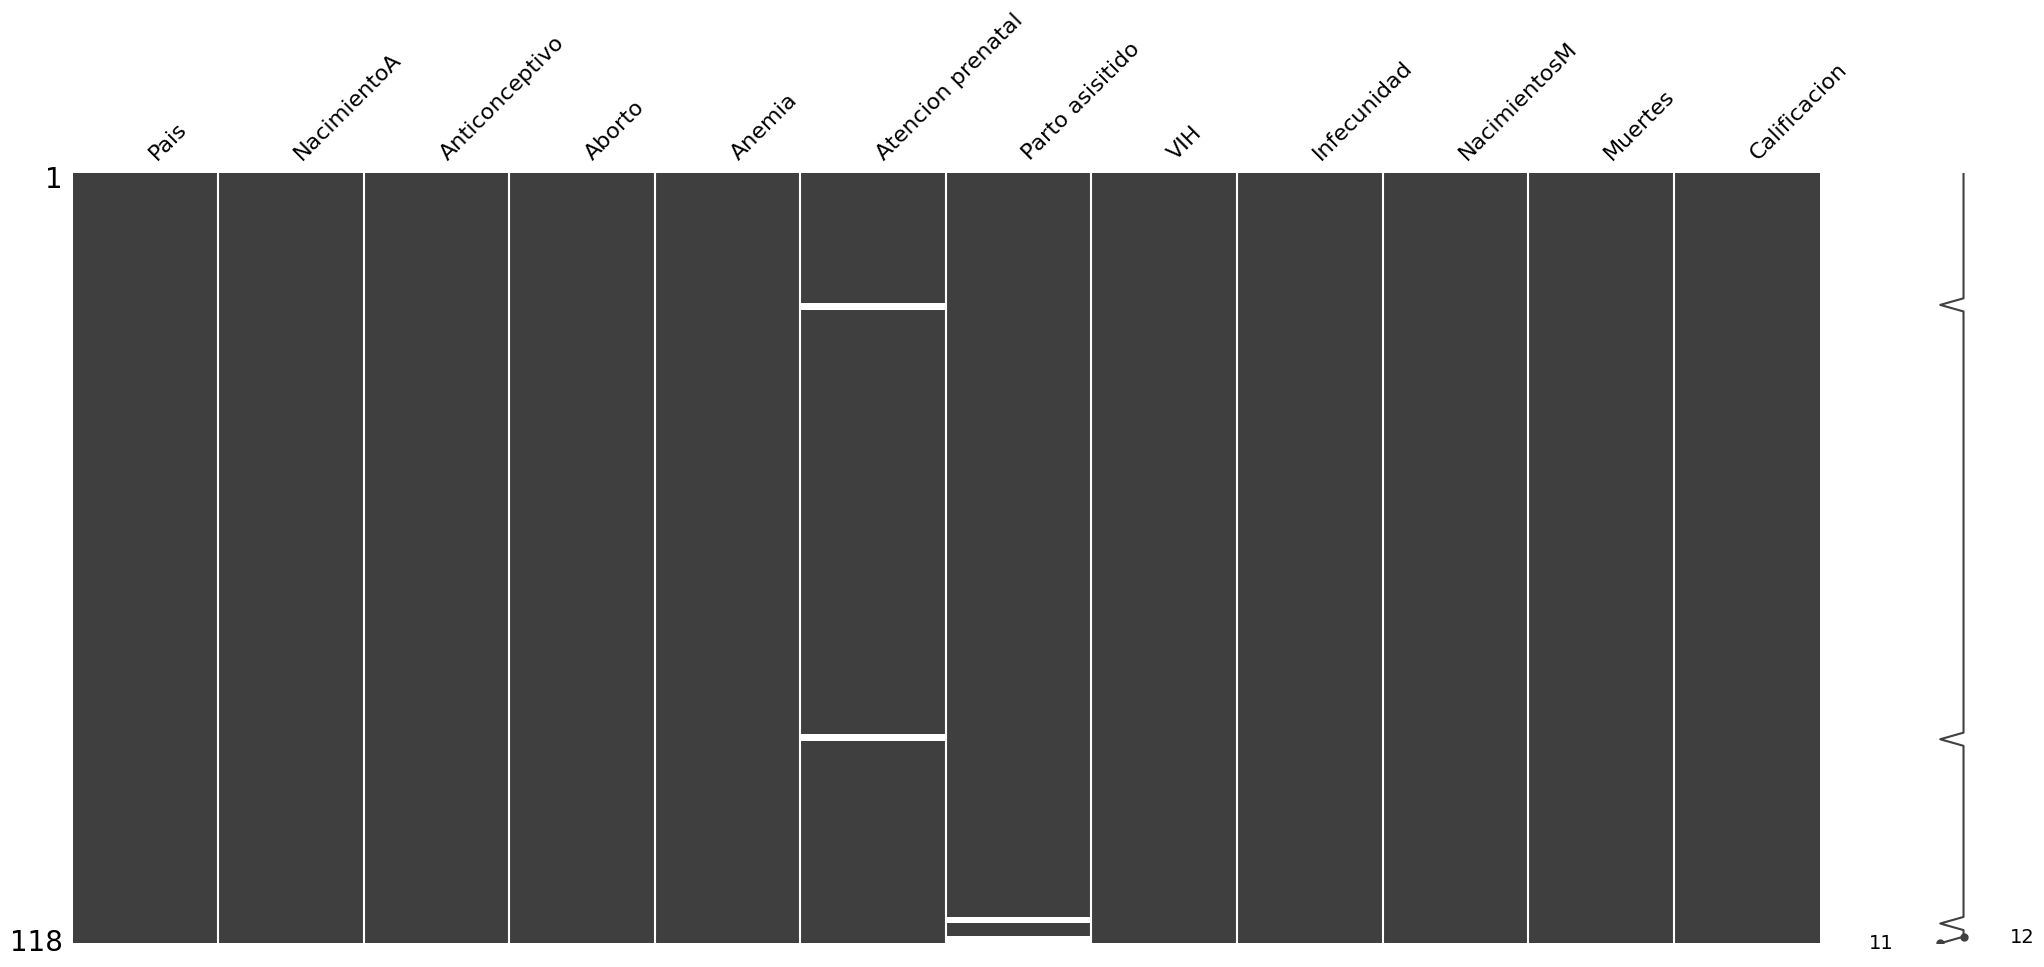

In [8]:
msno.matrix(data)

Contamos con datos faltantes en atencion prenatal y parto asistido, imputar con algún estadistico sería mala idea puesto que los paises distan bastante en sus condiciones de vida entre ellos, por lo cual la media quedaría en su mayoria por debajo o arriba de lo real.   
Por otra parte el parto asistido es algo más accesible respeto a la atención prenatal, pero no distan mucho entre ellas, entonces las usaremos para estimar esos valores, afortunadamente en ningun registro faltan ambos campos a la vez

### Create a new variable

In [29]:
ls_dif=[]
for index, row in data.iterrows():
    assisted = row['Parto asisitido']
    care=row['Atencion prenatal']
    if(pd.isna(assisted) or pd.isna(care)):
        ls_dif.append(0)
    else:
        ls_dif.append(assisted-care ) 

In [30]:
data["Diferencia"] = ls_dif

<AxesSubplot: >

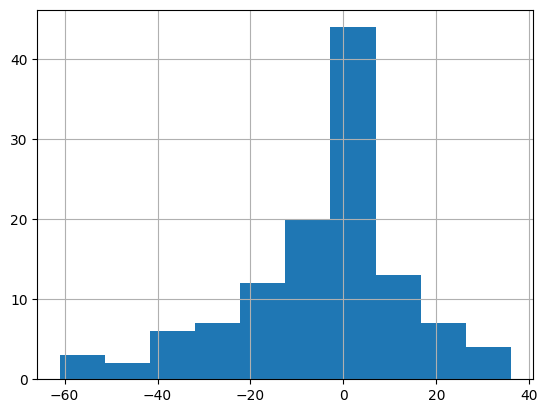

In [31]:
data["Diferencia"].hist()

In [32]:
data["Diferencia"].describe()

count    118.000000
mean      -4.872881
std       17.957950
min      -61.000000
25%      -13.500000
50%        0.000000
75%        4.000000
max       36.000000
Name: Diferencia, dtype: float64

In [35]:
len(data[data["Atencion prenatal"]> data["Parto asisitido"]])/ len(data)

0.4915254237288136

Como podemos observar si hay cierta relación en la diferencia por lo cual imputaremos con -5, añadiendo un numero aleatorio entre las desviaciones estandar y tambien vemos que esta equilibrado en cuantos casos es mayor o menor estos dos caracteristicas

### Impute data

In [47]:
df = data[data.columns[:-1]].copy()

In [48]:
ls_care=[]
ls_assi= []
for index, row in df.iterrows():
    assisted = row['Parto asisitido']
    care=row['Atencion prenatal']
    number= np.random.randint(-4,4,1)
    if(pd.isna(assisted)):
        new=care+5+number
        if(new>100):
            new= 99
        ls_assi.append(new[0])
        ls_care.append(care)
    elif(pd.isna(care)):
        new= assisted-5+number
        if(new>100):
            new= 99
        ls_assi.append(assisted)
        ls_care.append(new[0])
    else:
        ls_assi.append(assisted)
        ls_care.append(care)

In [49]:
df["Atencion prenatal"] = ls_care
df["Parto asisitido"] = ls_assi

In [51]:
df.sample(5)

,Pais,NacimientoA,Anticonceptivo,Aborto,Anemia,Atencion prenatal,Parto asisitido,VIH,Infecunidad,NacimientosM,Muertes,Calificacion
77,Honduras,13,47,5,42,45.0,81.0,2,3,5.2,221,47.7
16,Hong Kong,1,86,3,37,99.0,99.0,1,5,1.2,4,13.0
57,México,8,53,4,41,60.0,69.0,1,3,3.2,200,37.5
12,Reino Unido,3,81,2,19,98.0,98.0,1,6,1.8,8,11.8
43,Sri Lanka,3,62,5,62,86.0,94.0,1,4,2.5,80,31.0


# Data analysis

## Covariance matrix

In [67]:
df[df.columns[1:-1]].cov()

,NacimientoA,Anticonceptivo,Aborto,Anemia,Atencion prenatal,Parto asisitido,VIH,Infecunidad,NacimientosM,Muertes
NacimientoA,41.622555,-130.866652,5.255106,62.086846,-95.972403,-121.574895,2.402361,11.185716,10.340033,1468.027814
Anticonceptivo,-130.866652,736.848979,-22.801246,-319.304288,464.338621,620.322831,-9.351514,-38.528900,-51.492648,-6344.747211
Aborto,5.255106,-22.801246,2.214689,13.155150,-17.655367,-24.131682,0.294365,0.686513,1.857135,224.548167
Anemia,62.086846,-319.304288,13.155150,326.391786,-266.318195,-349.125960,4.973707,14.198899,24.297574,3651.032015
Atencion prenatal,-95.972403,464.338621,-17.655367,-266.318195,734.021512,662.924019,-1.762060,-9.905838,-35.471599,-5772.805157
Parto asisitido,-121.574895,620.322831,-24.131682,-349.125960,662.924019,917.533898,-8.156381,-29.028973,-47.408772,-7291.643778
VIH,2.402361,-9.351514,0.294365,4.973707,-1.762060,-8.156381,0.481023,1.567000,0.743655,99.247284
Infecunidad,11.185716,-38.528900,0.686513,14.198899,-9.905838,-29.028973,1.567000,12.675359,2.624555,455.545270
NacimientosM,10.340033,-51.492648,1.857135,24.297574,-35.471599,-47.408772,0.743655,2.624555,4.051781,459.690816
Muertes,1468.027814,-6344.747211,224.548167,3651.032015,-5772.805157,-7291.643778,99.247284,455.545270,459.690816,104712.978125


## Correlation matrix

<AxesSubplot: >

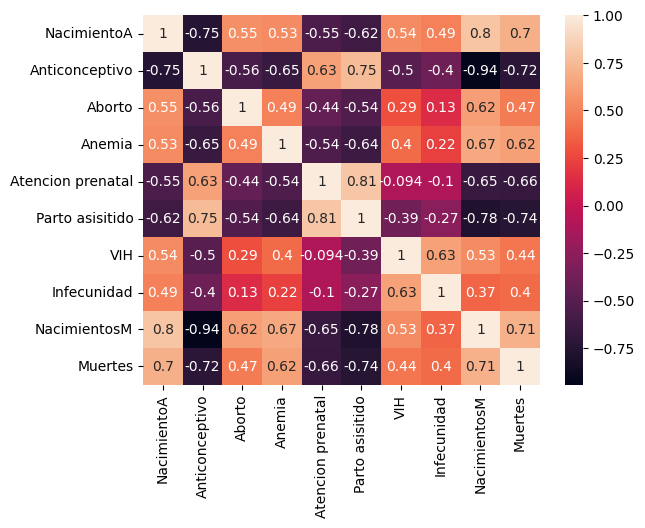

In [68]:
sns.heatmap(df[df.columns[1:-1]].corr(), annot=True)

Como podemos observar los valores que se tienen en la matriz de varianza covarianza son muy distintos entre ellos y muy grandes, debido a que las cantidades no se encuentran en el mismo rango y ante la falta de un scalado de las variables, nos arroja esos resultados.  
Por lo cual lo aporpiado en este caso es trabajar con la matriz de correlaciones al tener todos sus valores entre -1 a 1 

In [103]:
X= df[df.columns[1:-1]]

## Eingenvectors and eigenvalues

In [105]:
x,v=np.linalg.eig(X.corr())

Nuestros eingevalores son:

In [106]:
x

array([6.03750212, 1.39511377, 0.67081649, 0.50655939, 0.04436946,
       0.12128859, 0.22747328, 0.37391666, 0.32716005, 0.29580017])

Y sus repectivos eingenvectores son

In [107]:
print(v)

[[ 0.34607958  0.12977014  0.05953399  0.35040065  0.14154676 -0.26273456
   0.55671935 -0.14970534  0.48251349  0.28780445]
 [-0.37165348  0.01144929 -0.03285198 -0.04393583 -0.60919362 -0.11822207
   0.42006373  0.47735307 -0.07356722  0.25280041]
 [ 0.27017364 -0.17544268  0.77024566  0.26552675  0.03431357  0.08369602
  -0.08425494  0.44407329 -0.1268419  -0.06222492]
 [ 0.30867753 -0.12131509  0.08479168 -0.79699045  0.01373328 -0.04472052
   0.17780571  0.20139209  0.34626958 -0.23098187]
 [-0.30035844  0.40999773  0.40098359 -0.17822319 -0.03300009 -0.57686358
  -0.3768885  -0.13007537  0.19200266  0.13944593]
 [-0.35291571  0.20484409  0.22659748  0.01622703 -0.05808925  0.69762518
  -0.01603403 -0.08123883  0.53320813  0.02562537]
 [ 0.2408016   0.56772277  0.14931875 -0.29188947  0.08275563  0.27708273
   0.21029443 -0.1172948  -0.49535734  0.35387265]
 [ 0.19340195  0.63530902 -0.25698263  0.22248867 -0.07432356 -0.02362668
  -0.07955387  0.39500933  0.09179657 -0.51630112]


# PCA

Como habiamos comentado lo adecuado es usar la matriz de correlación, pero la biblioteca no tiene esa opción por lo cual optamos por escalar nuestros valores y asi la matris de varianza covarianza se asemeja a la de correlación

In [165]:
sx = StandardScaler().fit(X)
Xs= sx.transform(X)

In [166]:
pca= PCA(n_components=3)
pca.fit(Xs)

PCA(n_components=3)

## Components

Tomando a las variables como x1 hasta x10 dado el orden en la que se encuentra los datos cada componente se expresa de la siguiente manera.

In [173]:
coeffi=pca.components_
for i in range(3):
    component= 'Z'+str(i+1)
    string= str()
    for j in range(10):
        string+= "(" + str(np.round(coeffi[i][j], decimals=3)) +')x'+str(j+1) +' + '
    print(f'{component}= {string[:-2]}')
    print("-----------------------------------------------------------------------------------")
        

Z1= (0.346)x1 + (-0.372)x2 + (0.27)x3 + (0.309)x4 + (-0.3)x5 + (-0.353)x6 + (0.241)x7 + (0.193)x8 + (0.38)x9 + (0.346)x10 
-----------------------------------------------------------------------------------
Z2= (0.13)x1 + (0.011)x2 + (-0.175)x3 + (-0.121)x4 + (0.41)x5 + (0.205)x6 + (0.568)x7 + (0.635)x8 + (-0.025)x9 + (-0.031)x10 
-----------------------------------------------------------------------------------
Z3= (-0.06)x1 + (0.033)x2 + (-0.77)x3 + (-0.085)x4 + (-0.401)x5 + (-0.227)x6 + (-0.149)x7 + (0.257)x8 + (-0.119)x9 + (0.283)x10 
-----------------------------------------------------------------------------------


In [154]:
for i, column in enumerate(list(X.columns)):
    print(f'x{i+1} = {column}')

x1 = NacimientoA
x2 = Anticonceptivo
x3 = Aborto
x4 = Anemia
x5 = Atencion prenatal
x6 = Parto asisitido
x7 = VIH
x8 = Infecunidad
x9 = NacimientosM
x10 = Muertes


### Visualization

In [174]:
tabla_z = pca.transform(Xs)

In [175]:
df["Z1"] = tabla_z[:,0]
df["Z2"] = tabla_z[:,1]
df["Z3"] = tabla_z[:,2]

In [176]:
df.head()

,Pais,NacimientoA,Anticonceptivo,Aborto,Anemia,Atencion prenatal,Parto asisitido,VIH,Infecunidad,NacimientosM,Muertes,Calificacion,Z1,Z2,Z3
0,Italia,1,78,1,10,100.0,100.0,1,6,1.2,4,6.6,-3.541107,0.787288,0.789119
1,Dinamarca,1,78,1,8,100.0,99.0,1,6,1.8,3,6.7,-3.451153,0.786691,0.769639
2,Noruega,2,76,1,17,95.0,100.0,1,5,1.8,3,8.1,-3.225941,0.496949,0.709836
3,Suecia,1,78,1,17,100.0,100.0,1,5,2.0,5,8.4,-3.322953,0.550932,0.637130
4,Bélgica,1,79,1,17,90.0,100.0,1,7,1.6,3,8.7,-3.194167,0.762906,0.953891


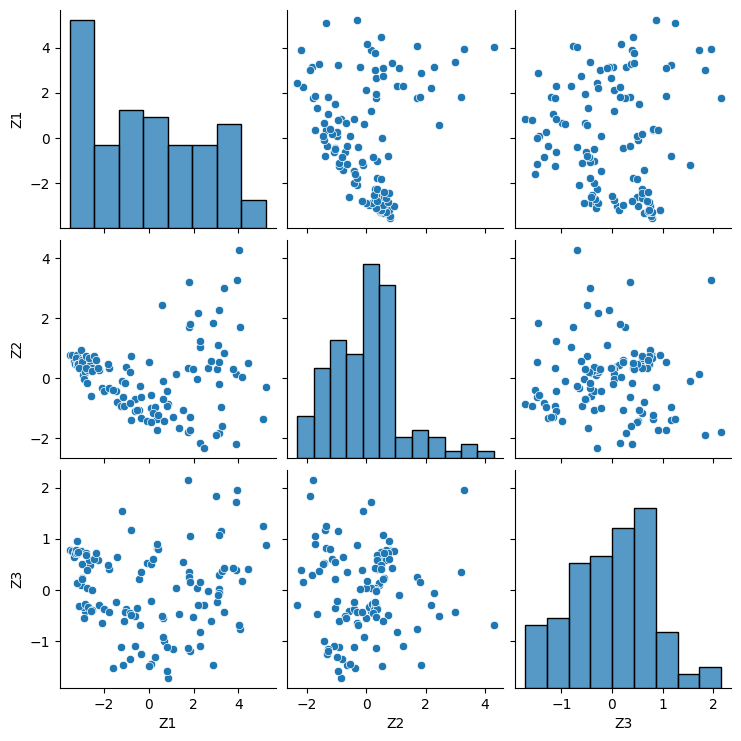

In [171]:
sns.pairplot(df[df.columns[-3:]])

Podemos notar segmentos donde hay una gran acumulación de puntos y algunos otros que llegan a estar bastante dispersos, sobretodo en la parte inferior de $Z1vsZ2$

## Explained variance

La varianza de cada uno de nuestros componentes $Z_1,Z_2,Z_3$ estan dados por los eingevalores de nuestra matriz de correlación de tal forma que ordenando de mayor a menor tenemos que:  
$$Var(Z_i)= \lambda_i$$

In [181]:
x[:3]

array([6.03750212, 1.39511377, 0.67081649])

In [178]:
pca.explained_variance_

array([6.08910471, 1.40703782, 0.67654997])

Y por tanto el porcentaje de varianza explicada se puede determinar como el eingevalor entre la suma de todos los eingevalores

In [182]:
total=sum(x)

In [183]:
x[:3]/total

array([0.60375021, 0.13951138, 0.06708165])

In [184]:
pca.explained_variance_ratio_

array([0.60375021, 0.13951138, 0.06708165])

## Selection of components

Como logramos observar en nuestros 3 componentes es que la varianza explicada baja cada vez más y ya para el tercer componente su aporte es muy bajo por lo cual tomamos la decisión de quedarnos con solo dos componentes, los cuales explican un $73\%$ de la varianza de los datos y nos ahorra tener que usar las otras 8 variables

## Interpretation of components

Analizamos de nuevo el peso de las componentes $Z_1, Z_2$, para ver a que le da más importancia

In [187]:
coeffi=pca.components_
for i in range(2):
    component= 'Z'+str(i+1)
    string= str()
    for j, column in enumerate(list(X.columns)):
        string+= "(" + str(np.round(coeffi[i][j], decimals=3)) +')'+ column +' + '
    print(f'{component}= {string[:-2]}')
    print("-----------------------------------------------------------------------------------")
        

Z1= (0.346)NacimientoA + (-0.372)Anticonceptivo + (0.27)Aborto + (0.309)Anemia + (-0.3)Atencion prenatal + (-0.353)Parto asisitido + (0.241)VIH + (0.193)Infecunidad + (0.38)NacimientosM + (0.346)Muertes 
-----------------------------------------------------------------------------------
Z2= (0.13)NacimientoA + (0.011)Anticonceptivo + (-0.175)Aborto + (-0.121)Anemia + (0.41)Atencion prenatal + (0.205)Parto asisitido + (0.568)VIH + (0.635)Infecunidad + (-0.025)NacimientosM + (-0.031)Muertes 
-----------------------------------------------------------------------------------


En $Z_1$:  
Veamos que la variable con mayor peso positivo, se tiene en **NacimientosM** que corresponde al promedio de nacimientos por mujer, esto es que considera un mayor riesgo entre más embarazos en promedio tiene las mujeres en ese determinado país.  
Tambien hacer hincapie en el peso que **NaciemientosA** que son los nacimientos anuales por 100 mujeres de 15 a 19 años, indicando otro aspecto que aumenta el riesgo son los nacimientos que se dan con madres de edades muy tempranas.  
Siendo aspectos positivos para reducir el riesgo de muerte el hecho de tener mayor porcentaje de **partos asisitidos y atención prenatal**, puesto que permiten un embarazo y concepción en mejores condiciones.

En $Z_2$ pasa algo interesante, puesto que sus pesos positivos recaen en aspectos favorables para la vida de la madre como son:  
- Parto asistido
- Atención prenatal  

Pero tambien en aspectos negativos como son:  
- VIH
- Anemia
- Infecunidad  

Que son fatores que un principio generan un embarazo peligroso o la incapcidad de tener uno.

## Correlation between Z1 and Target

<AxesSubplot: >

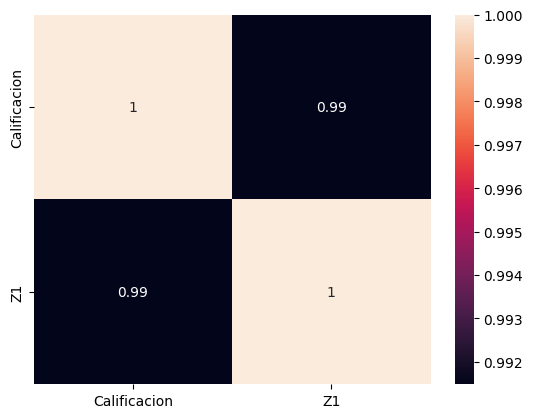

In [188]:
sns.heatmap(df[df.columns[-4:-2]].corr(), annot=True)

Y podemos observar una gran correlación entre nuestra componente y la calificación del riesgo por lo cual es muy probable que el indice de riesgo se construyo por medio de este componente, puesto que estan casi correlacionadas perfectamente.Por lo cual el calculo se obtiene escalando los valores que se tienen y multiplicando de la siguiente forma:

In [189]:
for j, column in enumerate(list(X.columns)):
    string+= "(" + str(np.round(coeffi[i][j], decimals=3)) +')'+ column +' + '
print(f'Califiación = {string[:-2]}')
print("-----------------------------------------------------------------------------------")

Califiación = (0.13)NacimientoA + (0.011)Anticonceptivo + (-0.175)Aborto + (-0.121)Anemia + (0.41)Atencion prenatal + (0.205)Parto asisitido + (0.568)VIH + (0.635)Infecunidad + (-0.025)NacimientosM + (-0.031)Muertes + (0.13)NacimientoA + (0.011)Anticonceptivo + (-0.175)Aborto + (-0.121)Anemia + (0.41)Atencion prenatal + (0.205)Parto asisitido + (0.568)VIH + (0.635)Infecunidad + (-0.025)NacimientosM + (-0.031)Muertes 
-----------------------------------------------------------------------------------


Donde las ponderaciones positivas representan un incremento en el riesgo y las negativas un factor que lo reduce